In [4]:
!pip install kaggle

from google.colab import files
import os

print('Please upload your kaggle.json file:')
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print('\nKaggle API configured successfully!')
else:
    print('\nKaggle.json not found. Please upload the file.')

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API configured successfully!


In [5]:
!kaggle datasets download -d gti-upm/leapgestrecog

!unzip -q leapgestrecog.zip

print("Dataset downloaded and unzipped.")

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.10G/2.13G [00:21<00:00, 263MB/s]
100% 2.13G/2.13G [00:23<00:00, 98.8MB/s]
Dataset downloaded and unzipped.


In [6]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define constants
IMG_SIZE = 128
# Correct the path to point to the nested directory
DATA_DIR = './leapgestrecog/leapGestRecog'

images = []
labels = []

# The gesture folders are named '01_palm', '02_l', etc.
# We will extract the number as the label.
gesture_map = {
    '01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4,
    '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9
}

print("Loading image data...")

# Iterate through each subject's folder (00, 01, ..., 09)
for subject_folder in os.listdir(DATA_DIR):
    subject_path = os.path.join(DATA_DIR, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    # Iterate through each gesture folder for the subject
    for gesture_folder, label in gesture_map.items():
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        # Iterate through each image in the gesture folder
        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)

print(f"Data loading complete. Loaded {len(images)} images.")

# Convert lists to numpy arrays
X = np.array(images, dtype='float32')
y = np.array(labels)

# Normalize pixel values to the range [0, 1]
X /= 255.0

# Add a channel dimension for the CNN (since it's grayscale)
X = np.expand_dims(X, axis=-1)

# One-hot encode the labels
y = to_categorical(y, num_classes=len(gesture_map))

# Split the data into training, validation, and testing sets (80-10-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nData shapes:")
print(f"Training set:   {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set:       {X_test.shape}, {y_test.shape}")

Loading image data...
Data loading complete. Loaded 20000 images.

Data shapes:
Training set:   (16000, 128, 128, 1), (16000, 10)
Validation set: (2000, 128, 128, 1), (2000, 10)
Test set:       (2000, 128, 128, 1), (2000, 10)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Flatten the features and feed into Dense layers
    Flatten(),

    # Dense Layers for Classification
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout for regularization to prevent overfitting
    Dense(len(gesture_map), activation='softmax') # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,944,266 (49.38 MB)

 Trainable params: 12,943,818 (49.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Define some training parameters
BATCH_SIZE = 64
EPOCHS = 10

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

print("\nTraining complete!")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7636 - loss: 1.8028 - val_accuracy: 0.1240 - val_loss: 13.1561
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9904 - loss: 0.0310 - val_accuracy: 0.2350 - val_loss: 14.7795
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9859 - loss: 0.0538 - val_accuracy: 0.8270 - val_loss: 1.9888
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9793 - loss: 0.1071 - val_accuracy: 0.9990 - val_loss: 0.0092
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9923 - loss: 0.0370 - val_accuracy: 0.9840 - val_loss: 0.0860
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9944 - loss: 0.0263 - val_accuracy: 0.9915 - val_loss: 0.0432
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9955 - loss: 0.0265 - val_accuracy: 0.9990 - val_loss: 0.0019
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9956 - loss: 0.0236 - 


Test Accuracy: 99.95%
Test Loss: 0.0014


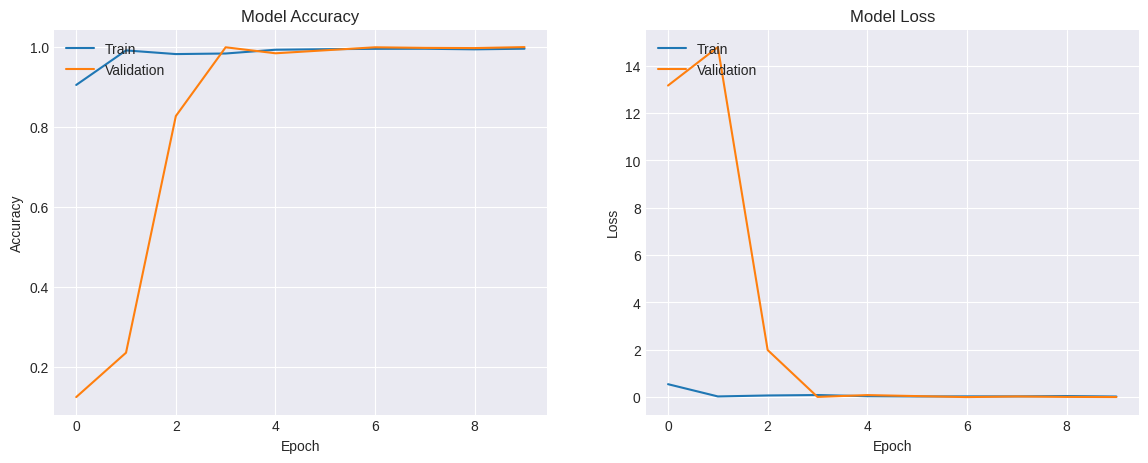

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


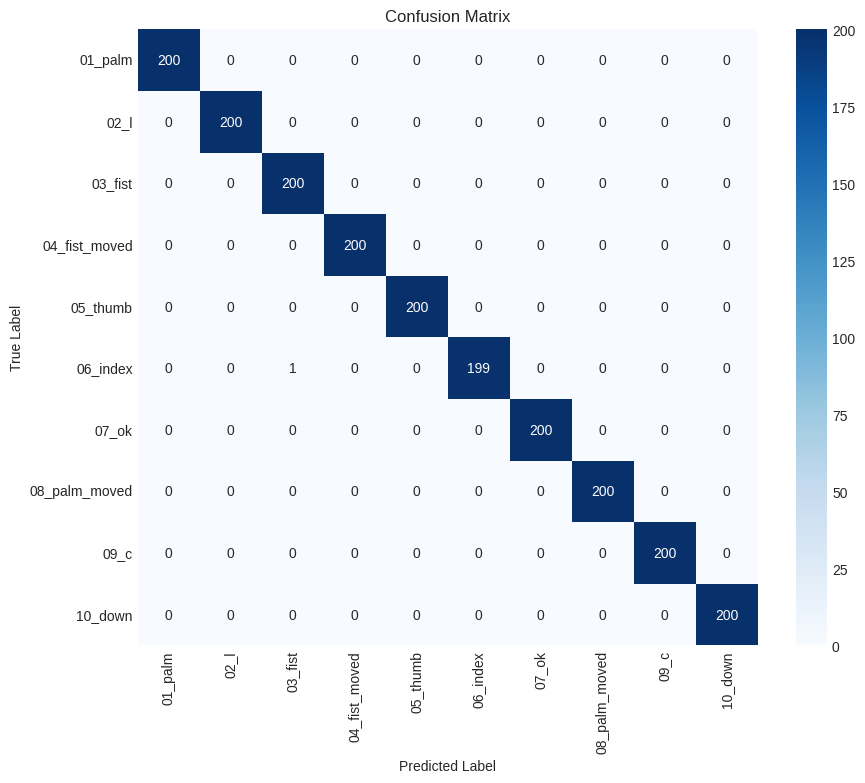


Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       200
         02_l       1.00      1.00      1.00       200
      03_fist       1.00      1.00      1.00       200
04_fist_moved       1.00      1.00      1.00       200
     05_thumb       1.00      1.00      1.00       200
     06_index       1.00      0.99      1.00       200
        07_ok       1.00      1.00      1.00       200
08_palm_moved       1.00      1.00      1.00       200
         09_c       1.00      1.00      1.00       200
      10_down       1.00      1.00      1.00       200

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Plotting training history
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# --- Confusion Matrix and Classification Report ---

# Get predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_map.keys(),
            yticklabels=gesture_map.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=gesture_map.keys()))

In [12]:
model.save('hand_gesture_model.keras')

print("Model saved to hand_gesture_model.keras")

from google.colab import files
files.download('hand_gesture_model.keras')

Model saved to hand_gesture_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>